Final assignment
===
* Group 3: Dominik Pegler • Elisa Grünauer • Lars Keuter
* Experiment 2: Positive instruction
* Course: Analyzing experimental-psychological data with R (Grüner & Forstinger)
---
**Content**

**1. Research question  
2. Import libraries  
3. Import data  
4. Data transformation and cleaning  
5. Power analysis  
6. Validity effects  
7. Visualization**
---
## 1. Research question

What validity effects can be found for the condition "Positive instruction"?**

* `key_responseTarget.corr_raw` = `answerCorrect`
* `key_responseTarget.rt_raw` = `reactionTime`
* `key_responseTarget.keys_raw` = which key was pressed by the participant

## 2. Import libraries

In [ ]:
# import libraries
library(data.table)
library(tidyverse)
library(viridis)

# default settings ggplot
theme_set(theme_minimal())
update_geom_defaults("bar", list(fill = "steelblue", alpha = 0.8))
update_geom_defaults("point", list(color = "steelblue", alpha = 0.8, size = 2.6))
update_geom_defaults("boxplot", list(fill = "steelblue", alpha = 0.8))

## 3. Import data

In [2]:
# import data
filelist <- list.files(path = "final_data", pattern = "*.txt", full.names = TRUE)
datalist <- lapply(filelist, function(x)read.table(x, header=T)) 
df <- do.call("rbind", datalist)
setDT(df) # Convert data.frame to data.table
cat(nrow(df), "rows")

34560 rows

## 4. Data transformation and cleaning

In [3]:
names(df)

[1] "cueType"                     "targetValidity"             
 [3] "CueDistractorPosition1"      "cueDistractor2_Position"    
 [5] "cueDistractor3_Position"     "InhibitionDistractor"       
 [7] "Target"                      "TargetColor"                
 [9] "gap_topleft"                 "gap_topright"               
[11] "gap_bottomright"             "gap_bottomleft"             
[13] "corrResp"                    "key_responseTarget.corr_raw"
[15] "key_responseTarget.rt_raw"   "sex"                        
[17] "hand"                        "key_responseTarget.keys_raw"
[19] "sbj"                         "order"                      
[21] "age"                         "instruction"

### 4.1 Limit to positive instructions only (variable `instruction`)

In [4]:
df <- df[df$instruction=="positive", ] # filter
df <- subset(df, select = -c(instruction)) # remove col
nrow_positive <- nrow(df)
cat(nrow_positive, "rows")

8640 rows

### 4.2 Limit to correct responses only (`key_responseTarget.corr_raw`)

In [5]:
df <- df[df$key_responseTarget.corr_raw == 1, ] # filter
df <- subset(df, select = -c(key_responseTarget.corr_raw)) # remove col
nrow_correct <- nrow(df)
cat(nrow_correct, " rows.\n\n", round(100*(1-nrow_correct/nrow_positive), 0), "% of the trials were removed due to incorrect response.", sep="")

7671 rows.

11% of the trials were removed due to incorrect response.

### 4.3 Remove variable `TargetColor` (is always blue)

In [6]:
df <- subset(df, select = -c(TargetColor)) # remove col

### 4.4 Remove redundant variable `key_responseTarget.keys_raw` (same info already in `corrResp`)

In [7]:
df <- subset(df, select = -c(key_responseTarget.keys_raw)) # remove col

### 4.5 Remove variables `age`, `sex` and `hand`

In [8]:
df <- subset(df, select = -c(age, sex, hand)) # remove col

### 4.6 Rename reaction time column to `reactionTime`, convert from factor to numeric and to milliseconds

In [9]:
df <- rename(df, reactionTime = key_responseTarget.rt_raw)
df$reactionTime <- parse_number(as.character(df$reactionTime), locale=locale(decimal_mark = ",")) * 1000 # 1000 -> seconds to milliseconds

### 4.7 Check variables

In [10]:
summary(df)

       cueType     targetValidity CueDistractorPosition1
 inhibition:2575   invalid:5751   topleft :5768         
 match     :2532   valid  :1920   topright:1903         
 non-match :2564                                        
                                                        
                                                        
                                                        
 cueDistractor2_Position cueDistractor3_Position  InhibitionDistractor
 bottomleft :1917        bottomleft:5749         bottomleft :1910     
 bottomright:5754        topright  :1922         bottomright:1921     
                                                 topleft    :1929     
                                                 topright   :1911     
                                                                      
                                                                      
         Target     gap_topleft  gap_topright gap_bottomright gap_bottomleft
 bottomleft :1920   down :2

### 4.8 Removing outliers

In [11]:
aggregate(df$sbj, list(df$sbj), FUN=length)

Group.1,x
1,388
2,370
3,341
4,394
5,409
6,406
7,398
8,392
9,408
10,405


Sbj 3 has the least corr responses (341), but is not really an outlier, I would therefor keep these data. Other option to remove outliers would be by error rate with  a e.g. a (one-sided?) Grubbs test.

### 4.9 Removing unrealistic response times

$\ge 1000 ms$ or $\le 150ms$

In [12]:
df <- df[df$reactionTime<=1000 & df$reactionTime >= 150,]
nrow_clean <- nrow(df)
cat(nrow_clean, " rows.\n\n", round(100*(1-nrow_clean/nrow_correct), 0), "% of the trials were removed due to unrealistic response times.", sep="")

7671 rows.

0% of the trials were removed due to unrealistic response times.

### 4.10 Final data

In [13]:
valid_match <- df[df$targetValidity=="valid" & cueType=="match", ]
valid_match_n <- aggregate(valid_match$sbj, list(valid_match$sbj), FUN=length)

valid_nonmatch <- df[df$targetValidity=="valid" & cueType=="non-match", ]
valid_nonmatch_n <- aggregate(valid_nonmatch$sbj, list(valid_nonmatch$sbj), FUN=length)

cat("After these exclusions, the number of valid matching trials ranged from ",
    min(valid_match_n$x)," to ", max(valid_match_n$x),
    " (M = ", mean(valid_match_n$x),", SD = ", sd(valid_match_n$x), ", Mdn = ", median(valid_match_n$x),
    "),and of valid non-matching trials from ", min(valid_nonmatch_n$x), " to ", max(valid_nonmatch_n$x),
    " (M = ", mean(valid_nonmatch_n$x), ", SD = ", sd(valid_nonmatch_n$x), ", Mdn = ", median(valid_nonmatch_n$x), ") per participant", sep="")

After these exclusions, the number of valid matching trials ranged from 24 to 36 (M = 32.05, SD = 2.981963, Mdn = 32),and of valid non-matching trials from 28 to 35 (M = 31.8, SD = 2.284962, Mdn = 33) per participant

In [14]:
sample_size <- length(unique(df$sbj))
cat("Our sample size is ", sample_size, " participants", sep="")

Our sample size is 20 participants

## 5. Power analysis

### 5.1 Create copy of data table with some additional variables for simulation

In [15]:
df_pwr <- df

df_pwr$condition <- paste(df_pwr$targetValidity, df_pwr$cueType, sep = "_")

# Variablen initiieren
vpn <- NULL
i <- NULL
j <- NULL
df_pwr$RTnormalized <- 0 

for (i in 1:length(unique(df_pwr$sbj))) { # Loop über alle Personen
  vpn_temp <- unique(df_pwr$sbj)[i] 
  for (j in 1:length(unique(df_pwr$condition))) { # Loop über alle Bedingungen pro Person (deshalb genestet [Loop im Loop])
    condition_temp <- unique(df_pwr$condition)[j] 
    meanRT_temp <- mean(df_pwr[condition == condition_temp & sbj == vpn_temp]$reactionTime) # mittlere Reaktionszeit für diese Bedingung ermitteln
    df_pwr[condition == condition_temp & sbj == vpn_temp]$RTnormalized <- 
      df_pwr[condition == condition_temp & sbj == vpn_temp]$reactionTime - meanRT_temp # mittlere Reaktionszeit von den Reaktionszeiten abziehen
  }
}

# Um die Reaktionszeiten wieder realistischer bzwl. leichter interpretierbar zu machen, addieren wir den Mittelwert aller Reaktionzeiten. Die Form der Verteilung bleibt davon unbeeinflusst.
df_pwr$RTnormalized_real <- df_pwr$RTnormalized + mean(df_pwr$reactionTime)

### 5.2 Create template data table

In [16]:
# copy from the real data used for the analysis
dt_template <- copy(df_pwr[, c("cueType", "targetValidity", "sbj")])

# remove non-existing levels
dt_template$sbj <- factor(dt_template$sbj, levels = (unique(dt_template$sbj)))

# change sbj to 1:end
levels(dt_template$sbj) <- c(1:length(unique(dt_template$sbj)))

### 5.3 Script

In [57]:
runSimulation <- function(dt_template, df, Nsim, effect, sampleSize, simSampleSize, trialChangeFactor){
    simList <- vector(mode = "list", length = Nsim)
    j <- NULL
    i <-  NULL
    for (j in 1:Nsim) {
      start.time <- Sys.time()
      simData <- copy(dt_template)
      if (simSampleSize < sampleSize) {
        randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize)
        simData <- simData[simData$sbj %in% randomSbj,]
        levels(simData$sbj)[levels(simData$sbj) %in% randomSbj] <- c(1:simSampleSize)
        } else if (simSampleSize > sampleSize) {
          sampleSizeIncrease <- simSampleSize - sampleSize
          if (sampleSizeIncrease <= sampleSize) {
            randomSbj <- sample(1:length(unique(simData$sbj)), sampleSizeIncrease)
            simDataAddition <- simData[simData$sbj %in% randomSbj,]
            simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
            levels(simDataAddition$sbj) <- c((sampleSize+1):(sampleSize+sampleSizeIncrease))
            simData <- rbind(simData, simDataAddition)
          } else if (sampleSizeIncrease > sampleSize) {
            simRepetition <- floor(simSampleSize / sampleSize)
            simDataBase <- simData[rep(seq_len(nrow(simData)), times = simRepetition), ]
            simDataBase$repetition <- rep(1:simRepetition, each = nrow(simData))
            simDataBase$sbj_new <- as.numeric(simDataBase$sbj)
            simDataBase$sbj_new <- simDataBase$sbj_new + sampleSize * (simDataBase$repetition-1)
            simDataBase$sbj <- as.factor(simDataBase$sbj_new)
            simDataBase$repetition <- NULL
            simDataBase$sbj_new <- NULL
            randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize %% sampleSize)
            simDataAddition <- simData[simData$sbj %in% randomSbj,]
            simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
            levels(simDataAddition$sbj) <-
            c((length(unique(simDataBase$sbj))+1):(sampleSize+sampleSizeIncrease))
            simData <- rbind(simDataBase, simDataAddition)
          }
        }

      if (trialChangeFactor < 1) {
        simData <- simData[sample(1:nrow(simData), round(nrow(simData) * trialChangeFactor))]
      } else if (trialChangeFactor > 1) {
        simData <- rbind(simData[rep(seq_len(nrow(simData)), times = floor(trialChangeFactor)), ],
                         simData[sample(1:nrow(simData), round(nrow(simData) * (trialChangeFactor-floor(trialChangeFactor))))])
      }

      for (i in 1:simSampleSize) {
        # simulates random interindividual variance
        individualRTvariance <-  rnorm(1, mean = 0, sd = 0.05)
        RT_var_sd <- 0.015
        RT_var1 <- rnorm(1, mean = 0, sd = RT_var_sd)
        RT_var2 <- rnorm(1, mean = 0, sd = RT_var_sd)
        RT_var3 <- rnorm(1, mean = 0, sd = RT_var_sd)
        RT_var4 <- rnorm(1, mean = 0, sd = RT_var_sd)
        RT_var5 <- rnorm(1, mean = 0, sd = RT_var_sd)
        RT_var6 <- rnorm(1, mean = 0, sd = RT_var_sd)

        # simulate reaction times per condition
        RT_1 <- sample(df$RTnormalized_real - effect + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "valid" & cueType == "match"]),
                       replace = TRUE) + RT_var1
        RT_2 <- sample(df$RTnormalized_real + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "valid" & cueType == "non-match"]),
                       replace = TRUE) + RT_var2
        RT_3 <- sample(df$RTnormalized_real + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "invalid" & cueType == "match"]),
                       replace = TRUE) + RT_var3
        RT_4 <- sample(df$RTnormalized_real + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "invalid" & cueType == "non-match"]),
                       replace = TRUE) + RT_var4
        RT_5 <- sample(df$RTnormalized_real + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "valid" & cueType == "inhibition"]),
                       replace = TRUE) + RT_var5
        RT_6 <- sample(df$RTnormalized_real + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "invalid" & cueType == "inhibition"]),
                       replace = TRUE) + RT_var6

        # Zuordnung der simulierten Reaktionszeiten zu den Faktorkombinationen
        simData[sbj == i & targetValidity == "valid" & cueType == "match", reactionTime := RT_1]
        simData[sbj == i & targetValidity == "valid" & cueType == "non-match", reactionTime := RT_2]
        simData[sbj == i & targetValidity == "invalid" & cueType == "match", reactionTime := RT_3]
        simData[sbj == i & targetValidity == "invalid" & cueType == "non-match", reactionTime := RT_4]
        simData[sbj == i & targetValidity == "valid" & cueType == "inhibition", reactionTime := RT_5]
        simData[sbj == i & targetValidity == "invalid" & cueType == "inhibition", reactionTime := RT_6]
      }

      simData[, simNo := j] # ergänzt neue Variable mit der Nummer der Simulation
      simList[[j]] <- copy(simData) # speichert das fertige simulierte Datenframe in die Liste mit den Simulationen
      end.time <- Sys.time() # End-Zeit der Simulation eines Datensatzes
      time.taken <- end.time - start.time # Dauer der Simulation eines Datensatzes
    }

    simData <- rbindlist(simList)

    # Zuletzt vergleichen wir noch die Standardabweichungen der Reaktionzeiten in den Bedingungen der realen und simulierten Daten
    data_trimmed_means_sbj <- df[, .(meanRT = mean(reactionTime)),
                                           by = .(sbj, cueType, targetValidity)]

    data_trimmed_sd <- data_trimmed_means_sbj[, .(SD = sd(meanRT)), by = .(targetValidity, cueType)]

    simData_trimmed_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                                         by = .(sbj, targetValidity, cueType, simNo)]

    simData_trimmed_sd_sim <- simData_trimmed_means_sbj[, .(SD = sd(meanRT)),
                                                        by = .(targetValidity, cueType, simNo)]

    simData_trimmed_sd <- simData_trimmed_sd_sim[, .(SD = mean(SD)),
                                                 by = .(targetValidity, cueType)]

    # Berechnung des Validitätseffeks
    simData_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                                 by = .(simNo, targetValidity, cueType, sbj)]

    simValidityEffect <- simData_means_sbj[, .(validityEffect = meanRT[targetValidity == "invalid"] -
                                                                meanRT[targetValidity == "valid"]),
                                           by = .(cueType, sbj, simNo)]
    # Ergebnisse berechnen
    simValidityEffect_results <- simValidityEffect[,
                                     .(meanValidityEffect = t.test(validityEffect, mu = 0)$estimate,
                                       p.value = t.test(validityEffect, mu = 0)$p.value,
                                       t.stat = t.test(validityEffect, mu = 0)$statistic),
                                     by = .(simNo, cueType)]

    sigNiveau <- 0.05 # Signifikanzniveau definieren

    powerResults <- simValidityEffect_results[t.stat > 0 & p.value < sigNiveau,
                                              .(EffectFound = .N,
                                                Nsim = max(simValidityEffect_results$simNo),
                                                testPower = .N / max(simValidityEffect_results$simNo)),
                                              by = .(cueType)]

    return(powerResults)}

### 5.4 Determine power

In [67]:
condition <- "match"

n_sims <- 1000
effect_est <- 20 # 20 ms validity effect (smallest relevant effect size)
sim_sample_size <- sample_size # sample size for simulation (can be changed!)
trial_change_factor <- 1 # change factor for trial number to increase or decrease trial number

res <- runSimulation(dt_template, df_pwr, n_sims, effect_est, sample_size, sim_sample_size, trial_change_factor)
pwr <- res[res$cueType==condition, ]$testPower

cat(
    "A power analysis based on ", 
    n_sims, " simulations yielded a power of ", 
    pwr, " to find a validity effect of ", 
    effect_est, " ms in the condition positive instruction and ", 
    condition, " with the sample size of ", sample_size, " participants.",
    sep=""
)

A power analysis based on 1000 simulations yielded a power of 0.987 to find a validity effect of 20 ms in the condition positive instruction and match with the sample size of 20 participants.

## 6. Validity effects

### 6.1 Means, SD, n

#### 6.1.1 Valid trials

In [15]:
nrow(df[df$targetValidity=="valid", ])

[1] 1920

In [16]:
mean(df[df$targetValidity=="valid", reactionTime])

[1] 543.5758

In [17]:
sd(df[df$targetValidity=="valid", reactionTime])

[1] 113.2674

#### 6.1.2 Invalid trials

In [18]:
nrow(df[df$targetValidity=="invalid", ])

[1] 5751

In [19]:
mean(df[df$targetValidity=="invalid", reactionTime])

[1] 559.1591

In [20]:
sd(df[df$targetValidity=="invalid", reactionTime])

[1] 104.0098

### 6.3 Validity effects

#### 6.3.1 Overall

In [21]:
mean(df[df$targetValidity=="invalid", reactionTime]) - mean(df[df$targetValidity=="valid", reactionTime])

[1] 15.5833

In [68]:
# p-values (t-test) here

#### 6.3.2 Condition "match"

In [22]:
cT <- "match"
mean(df[df$targetValidity=="invalid" & cueType==cT, reactionTime]) - mean(df[df$targetValidity=="valid" & cueType==cT, reactionTime])

[1] 71.04696

In [68]:
# p-values (t-test) here

#### 6.3.3 Condition "non-match"

In [23]:
cT <- "non-match"
mean(df[df$targetValidity=="invalid" & cueType==cT, reactionTime]) - mean(df[df$targetValidity=="valid" & cueType==cT, reactionTime])

[1] -18.43878

In [68]:
# p-values (t-test) here

#### 6.3.4 Condition "inhibition"

In [24]:
cT <- "inhibition"
mean(df[df$targetValidity=="invalid" & cueType==cT, reactionTime]) - mean(df[df$targetValidity=="valid" & cueType==cT, reactionTime])

[1] -5.317096

In [68]:
# p-values (t-test) here

## 7. Visualization

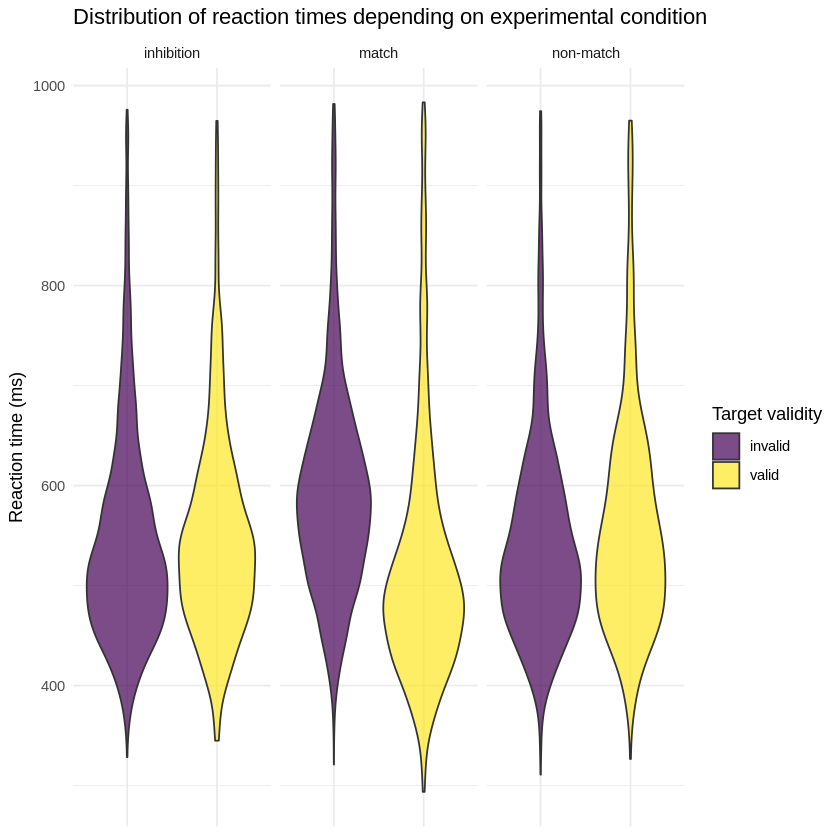

In [25]:
ggplot(df, aes(x=targetValidity, y=reactionTime)) + 
geom_violin(aes(fill=targetValidity), alpha=0.7) +
facet_wrap(~ cueType) +
scale_fill_viridis(discrete=TRUE) +
xlab("") +
ylab("Reaction time (ms)") + 
labs(title="Distribution of reaction times depending on experimental condition", fill = "Target validity") +
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())

Validity effects are only visible in the condition with cue-type "match".